# **FILM Recomendation system using Longformer**

Created By : Rendra Dwi Prasetyo

## **I. Import Dataset**

Dataset Source : [Dataset](https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots)

In [ ]:
# Uploading API key (json) file from kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rendraprasetyo","key":"4bad7239e9e86f57b87632f6967fd0f9"}'}

In [ ]:
# Create file directories and move files "kaggle.json"
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Donwload dataset
!kaggle datasets download jrobischon/wikipedia-movie-plots

Dataset URL: https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots
License(s): CC-BY-SA-4.0
 63% 19.0M/29.9M [00:00<00:00, 104MB/s] 
100% 29.9M/29.9M [00:00<00:00, 127MB/s]


In [ ]:
# Check whether the dataset is already on the Google Colab disk
!ls

kaggle.json  sample_data  wikipedia-movie-plots.zip


In [ ]:
# Extract/unzip the dataset that I downloaded earlier
!unzip wikipedia-movie-plots.zip -d data_dir

Archive:  wikipedia-movie-plots.zip
  inflating: data_dir/wiki_movie_plots_deduped.csv  


## **II. Exploration Dataset**

**Load dataset**

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('./data_dir/wiki_movie_plots_deduped.csv')

In [ ]:
# check header dataset
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [ ]:
# Get the number of rows in the dataframe
num_rows = len(df)

# Print the number of rows
print(f"The dataframe has {num_rows} rows.")

The dataframe has 34886 rows.


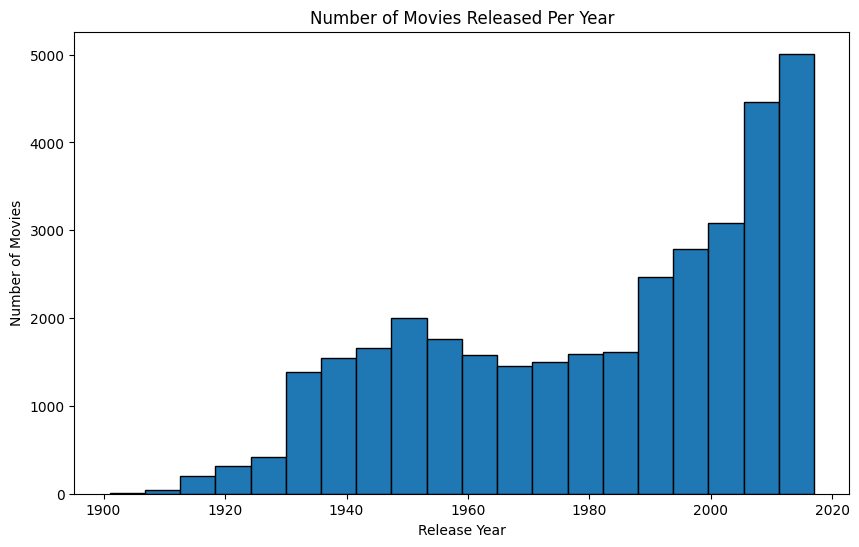

In [ ]:
# @title Number of Movies Released Per Year

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df['Release Year'], bins=20, edgecolor='black')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
_ = plt.title('Number of Movies Released Per Year')

**Right-Skewed (Positively Skewed)**: The distribution is likely to be right-skewed. This means that the tail of the distribution extends longer on the right side (towards more recent years). This is common in datasets where there's an increase in the number of movies produced over time.

In [ ]:
# check all feature/columns
df.columns

Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot'],
      dtype='object')

In [ ]:
# Display unique genres
unique_genres = df['Genre'].unique()
unique_genres

array(['unknown', 'western', 'comedy', ...,
       'adventure, romance, fantasy film', 'ero',
       'horror romantic comedy'], dtype=object)

In [ ]:
# Count the number of movies with the genre "unknown"
unknown_genre_count = df[df['Genre'] == 'unknown']['Genre'].count()

# Print the result
print(f"Number of movies with the genre 'unknown': {unknown_genre_count}")

Number of movies with the genre 'unknown': 6083


**I performed imputation for genre with Albert**

Changing the unkown Genre by imputation with Albert being the most relevant genre

In [ ]:
!pip install transformers

In [ ]:
from transformers import AlbertTokenizer, AlbertForSequenceClassification
import torch

# Load pre-trained ALBERT model and tokenizer
model_name = "albert-base-v2"  # Or any other suitable ALBERT model
tokenizer = AlbertTokenizer.from_pretrained(model_name)
model = AlbertForSequenceClassification.from_pretrained(model_name, num_labels=len(df['Genre'].unique())) # Assuming you have unique genres

# Example usage
def impute_genre(plot):
  inputs = tokenizer(plot, return_tensors="pt", padding=True, truncation=True, max_length=512)
  with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
  predicted_class_id = logits.argmax().item()
  return list(df['Genre'].unique())[predicted_class_id] # Get the genre from the list of unique genres


# Apply the impute_genre function to rows where 'Genre' is 'unknown'
df.loc[df['Genre'] == 'unknown', 'Genre'] = df.loc[df['Genre'] == 'unknown', 'Plot'].apply(impute_genre)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Check unique genres once again
unique_genres = df['Director'].unique()
unique_genres

array(['Unknown', 'George S. Fleming, Edwin S. Porter', 'Cecil Hepworth',
       ..., 'Selçuk Aydemir', 'Brendan Bradley', 'Ferzan Özpetek'],
      dtype=object)

In [ ]:
# Save the updated DataFrame to a CSV file
df.to_csv('updated_df_2.csv', index=False)

# Download the CSV file
from google.colab import files
files.download('updated_df_2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Check for null values in each column
null_counts = df.isnull().sum()
print(null_counts)

# Check for specific columns
print(f"Null values in 'Director' column: {df['Director'].isnull().sum()}")
print(f"Null values in 'Genre' column: {df['Genre'].isnull().sum()}")

Release Year           0
Title                  0
Origin/Ethnicity       0
Director               0
Cast                1422
Genre                  0
Wiki Page              0
Plot                   0
dtype: int64
Null values in 'Director' column: 0
Null values in 'Genre' column: 0


Below proportion of empty values ​​in "Cast" column

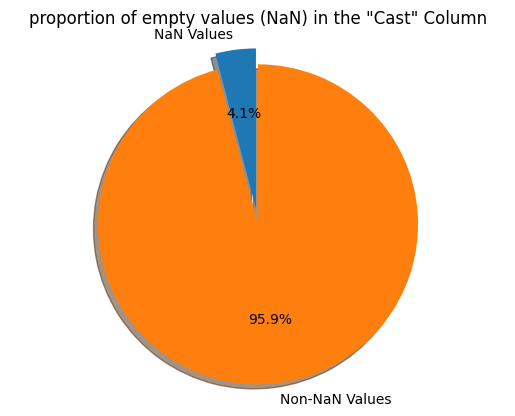

In [ ]:
import matplotlib.pyplot as plt


# Calculate the number of NaN values and non-NaN values in the 'Director' column
nan_counts = df['Cast'].isnull().sum()
non_nan_counts = len(df) - nan_counts

# Create the pie chart
labels = ['NaN Values', 'Non-NaN Values']
sizes = [nan_counts, non_nan_counts]
explode = (0.1, 0)  # Explode the NaN slice

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('proportion of empty values (NaN) ​​in the "Cast" Column')
plt.show()

**I Decided not to use Cast as a feature** was a rational move because:

1. Cast value is not always relevant to the user.
2. The proportion of data with NaN is small, but deleting or handling Cast requires additional resources without major benefit.

#### **Length of text**

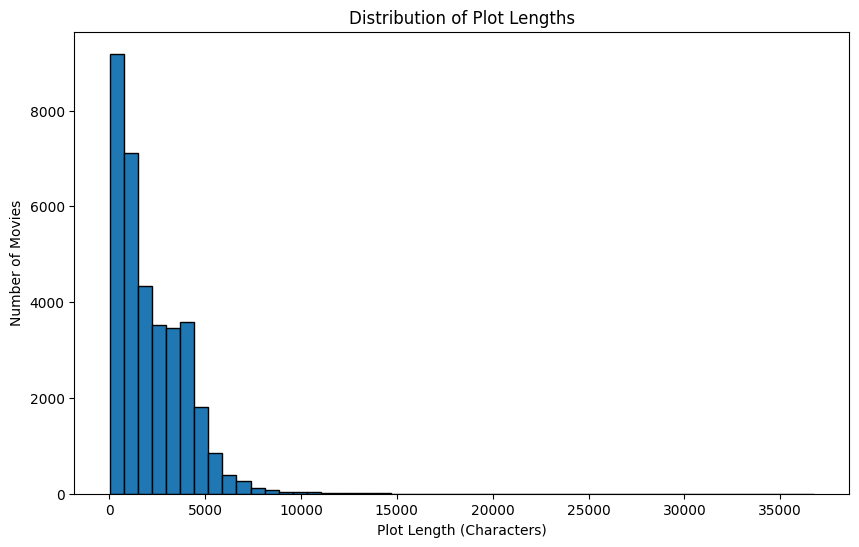

In [ ]:
# Calculate the length of each plot
plot_lengths = df['Plot'].str.len()

# Create the plot
plt.figure(figsize=(10, 6))
plt.hist(plot_lengths, bins=50, edgecolor='black')
plt.xlabel('Plot Length (Characters)')
plt.ylabel('Number of Movies')
plt.title('Distribution of Plot Lengths')
plt.show()

In [ ]:
# Calculate the number of plots with length greater than 10,000
long_plots_count = len(df[df['Plot'].str.len() > 8000])

# Print the result
print(f"Number of plots with length greater than 8,000: {long_plots_count}")

Number of plots with length greater than 8,000: 251


The majority of movie plots fall within a character length of 0 to 5,000.
As the plot length increases, the frequency decreases significantly, with very few movies exceeding 15,000 characters.

**So the conclusion after a series of data exploration**

The main factors for a recommendation system:


1. **Plot**: To understand the story.(Most importante)
2. **Genre**: To identify user preferences. (Most important)
3. **Origin/Ethnicity**: If relevant to the target audience. (importante)
4. **Release Year**: To provide a time filter. (importante)

And I will ignore it for:

1. **Cast**
2. **Director**

In [ ]:
df_new = df.drop(['Cast', 'Director', 'Wiki Page'], axis=1)

In [ ]:
df_new.head()

,Release Year,Title,Origin/Ethnicity,Genre,Plot
0,1901,Kansas Saloon Smashers,American,"animated, family, western","A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,"animated, family, western","The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,"animated, family, 3d","The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,"animated, family, 3d",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"animated, family, western",The earliest known adaptation of the classic f...


In [ ]:
# Save the updated DataFrame to a CSV file
df_new.to_csv('updated_df_3.csv', index=False)

# Download the CSV file
from google.colab import files
files.download('updated_df_3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## HGpus ini

In [2]:
import pandas as pd

In [3]:
df_new = pd.read_csv('./DF_NEW.csv', sep=',')

In [4]:

df_new = df_new.drop(['Cast', 'Director', 'Wiki Page'], axis=1)


In [5]:
import matplotlib.pyplot as plt

## Batas Hapus Ini

In [ ]:
df_new.isnull().sum()

,0
Release Year,0
Title,0
Origin/Ethnicity,0
Genre,0
Plot,0


I took one example text to assume approximately how many tokens will be generated


Token indices sequence length is longer than the specified maximum sequence length for this model (1796 > 512). Running this sequence through the model will result in indexing errors


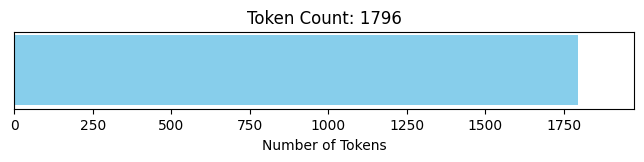

The selected plot has 1796 tokens.


In [ ]:
from transformers import AutoTokenizer

# Filter the DataFrame for plot lengths between 7000 and 8000
filtered_df = df_new[(df_new['Plot'].str.len() >= 7000) & (df_new['Plot'].str.len() <= 8000)]

# Select a single plot for demonstration
if not filtered_df.empty:
  plot = filtered_df['Plot'].iloc[0]

  # Tokenize the plot
  tokenizer = AutoTokenizer.from_pretrained("albert-base-v2") # Make sure to initialize tokenizer
  tokens = tokenizer.encode(plot, add_special_tokens=True)

  # Calculate the number of tokens
  num_tokens = len(tokens)

  # Create the plot (a simple horizontal bar chart)
  plt.figure(figsize=(8, 1)) # Adjust figure size if needed
  plt.barh([0], num_tokens, color='skyblue') #Horizontal bar chart
  plt.yticks([])  # Remove y-axis ticks
  plt.title(f"Token Count: {num_tokens}")
  plt.xlabel("Number of Tokens")
  plt.xlim(0, num_tokens * 1.1) # Set x-axis limit
  plt.show()

  print(f"The selected plot has {num_tokens} tokens.")
else:
  print("No plots found within the specified length range.")

It is clear that the number of tokens can be said to be very large so a model with sufficient capacity is needed, so the model I use is **Longformer**

## **III. Preprocessing Text : Longformer**

In [ ]:
from transformers import LongformerTokenizerFast

#Load the Longformer tokenizer
tokenizer = LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096')

df_nlp = df_new

# Tokenize the 'Plot' column of df_new
df_nlp['tokenized_plot'] = df_nlp['Plot'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=4096))

# Now df_new has a new column 'tokenized_plot' containing the tokenized plots
print(df_nlp.head())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

   Release Year                             Title Origin/Ethnicity  \
0          1901            Kansas Saloon Smashers         American   
1          1901     Love by the Light of the Moon         American   
2          1901           The Martyred Presidents         American   
3          1901  Terrible Teddy, the Grizzly King         American   
4          1902            Jack and the Beanstalk         American   

                       Genre  \
0  animated, family, western   
1  animated, family, western   
2       animated, family, 3d   
3       animated, family, 3d   
4  animated, family, western   

                                           Wiki Page  \
0  https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...   
1  https://en.wikipedia.org/wiki/Love_by_the_Ligh...   
2  https://en.wikipedia.org/wiki/The_Martyred_Pre...   
3  https://en.wikipedia.org/wiki/Terrible_Teddy,_...   
4  https://en.wikipedia.org/wiki/Jack_and_the_Bea...   

                                                P

**Padding**

In [ ]:
from transformers import LongformerModel
import torch

# Load the Longformer model to the desired device (cuda:0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #Define device
model = LongformerModel.from_pretrained('allenai/longformer-base-4096').to(device) # Load to device


# 1. Reduce batch size: Process data in smaller chunks.
batch_size = 32  # Experiment started with smaller batch sizes

# 2. Process data in batches: Loop through the data.
embeddings = []  # Store embeddings here
for i in range(0, len(padded_plots), batch_size):
    batch_input_ids = padded_plots[i:i + batch_size].to(device)
    batch_attention_masks = attention_masks[i:i + batch_size].to(device)

    with torch.no_grad():
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1)
    embeddings.append(batch_embeddings)

# 3. Concatenate embeddings:
embeddings = torch.cat(embeddings, dim=0)

verification dimension of embedding

In [ ]:
print(f"Shape of embeddings: {embeddings.shape}")

Shape of embeddings: torch.Size([34886, 768])


In [ ]:
# Save the embeddings to a file
torch.save(embeddings, 'movie_embeddings.pt')

# loaded_embeddings = torch.load('movie_embeddings.pt')

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

In [6]:
import torch

# Load the embeddings with map_location set to 'cpu'
embeddings = torch.load('movie_embeddings.pt', map_location=torch.device('cpu'))

<ipython-input-6-81759e4ffd35>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load('movie_embeddings.pt', map_location=torch.device('cpu'))


In [7]:
df_nlp = df_new.copy()

normalization of embedding

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(embeddings.cpu().numpy())

cosine_similarity

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix, save_npz, load_npz
import numpy as np

# Assume `embeddings` is the Longformer embedding matrix
cosine_sim = cosine_similarity(embeddings)

# Apply a threshold to remove small similarities
threshold = 0.5
cosine_sim[cosine_sim < threshold] = 0

# Convert to sparse format
sparse_cosine_sim = csr_matrix(cosine_sim)


In [10]:
# Extract pairs with similarity > threshold
rows, cols = np.where(cosine_sim > threshold)
similarities = cosine_sim[rows, cols]

similarity_df = pd.DataFrame({
    'item_a': rows,
    'item_b': cols,
    'similarity': similarities
})


In [11]:
from sklearn.neighbors import NearestNeighbors

# Fit Nearest Neighbors model
model = NearestNeighbors(metric="cosine", algorithm="brute")
model.fit(embeddings)

NearestNeighbors(algorithm='brute', metric='cosine')

In [12]:
# Save the model
import joblib
joblib.dump(model, "recommendation_model.pkl")

['recommendation_model.pkl']